In [1]:
%pip install composable

In [5]:
from composable import pipeable

In [6]:
from composable.strict import map, filter

In [7]:
import seaborn as sns

# Iteration Patterns

In this notebook, we will explore two main types of iteration patterns that cover most applications of iteration.  These are

1. `reduce`/`fold` for iteration of a predetermined length
2. `unfold`/`iterate` for other iteration.

## Two Types of Iteration

- **Count-controlled** iteration has fixed, predetermined length. Examples include `for` loops and comprehensions on existing lists/sets/tuples/dict.
- **Condition-controlled.** iteration doesn't end until we meet some condition with a length that can't be predetermined.  Examples include `while` loops, comprehensions on some generator object, and the function `unfold`/`iterate`.

In [8]:
# while loop can do what for loop does
# BUT, for loop is safer than while loop

### Example - Coin Flips

Suppose that we have a biased coin that comes up heads with probability $p$.  For convenience, we will code a head as the number `1` and a tail as `0`.

- **Count-controlled example.** We flip the coin $n$ times and record the number of heads (e.g., the binomial distribution).
- **Condition-controlled example.** We flip a coin until we see $k$ successes. 

#### Example 1 - Flipping a coin a $n$ times

In [9]:
from random import random

# if number is 1 to p then 1 
# random() gives 1 - 0 
flip = pipeable(lambda p: 1 if random() <= p else 0) 

In [10]:
n_flips = pipeable(lambda p, n, i: [flip(p) for j in range(n)])

In [11]:
n_flips(0.5, 10, 1)

[1, 0, 0, 0, 1, 0, 1, 0, 0, 1]

In [12]:
(trials := [n_flips(0.5, 10, i) for i in range(10000)])[:10]

[[0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 0, 1, 0, 0, 1, 1],
 [0, 0, 0, 0, 1, 1, 0, 1, 1, 1],
 [1, 0, 1, 0, 0, 1, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 0, 1, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
 [0, 1, 0, 1, 0, 0, 1, 1, 1, 1],
 [0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
 [1, 0, 1, 1, 1, 1, 1, 1, 0, 1]]

In [13]:
# 3 (3 = total 1) out of 10 succcesses . . . 
(successes := [sum(sample) for sample in trials])[:10]

[3, 5, 6, 5, 4, 4, 7, 6, 7, 8]

<Axes: ylabel='Count'>

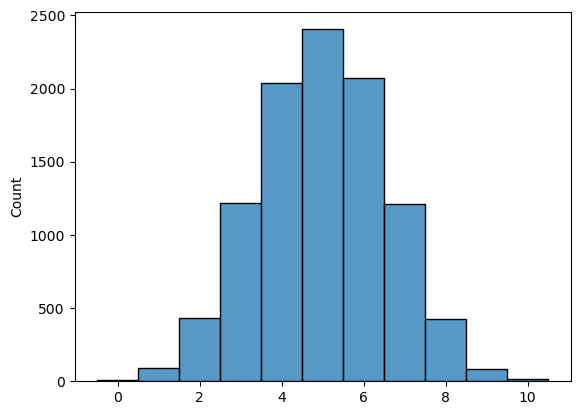

In [14]:
sns.histplot(successes, discrete=True)

#### Main point 1 - We can accumulate the (count-controlled) successes using a `for` loop and the *accumulator* pattern

In [15]:
n = 10
p = 0.5

successes = 0
for i in range(n):
    successes = successes + flip(p)

successes

5

#### Example 2 - Flipping a coin until 5 heads

In [16]:
# binomial = try 100 times and count how many suceesses you make
# negative binomial = keep shooting until you make 100 success

In [18]:
k = 5
failures = 0
successes = 0
while successes < k:
    this_flip = flip(0.5)
    successes, failures = successes + this_flip, failures + (1 - this_flip)
    print(f"Success: {successes}, Failure: {failures}")

Success: 1, Failure: 0
Success: 1, Failure: 1
Success: 2, Failure: 1
Success: 2, Failure: 2
Success: 2, Failure: 3
Success: 2, Failure: 4
Success: 3, Failure: 4
Success: 3, Failure: 5
Success: 3, Failure: 6
Success: 3, Failure: 7
Success: 3, Failure: 8
Success: 4, Failure: 8
Success: 5, Failure: 8


#### Main point 2 - We can count failures using a `while` loop and the *accumulator* pattern.

We will explore this pattern more in the next lecture/notebook.

## Understanding `reduce`/`fold`

We can abstract the accumulator pattern on `for` loops as `reduce` or `fold`.  I will use the `polars` definitions of `fold` and `reduce`

- `fold` takes a sequence and an explicit initial value, but
- `reduce` uses the first value in the sequence as the initial value.

#### Previous example - Number of successes in 10 flips

In [20]:
n = 10
p = 0.5

successes = 0
for i in range(n):
    successes = successes + flip(p)

successes

4

#### Pre-generate the sequence (count-controlled)

In [21]:
n = 10
p = 0.5

(flips := [flip(p) for i in range(n)])

[1, 0, 1, 1, 0, 1, 0, 0, 0, 1]

#### We can loop over the count-controlled sequence

In [22]:
successes = 0
for f in flips:
    successes = successes + f

successes

5

#### We can abstract the pattern with functions

In [23]:
update = pipeable(lambda acc, val: acc + val)

In [24]:
acc = 0   # Initial value
for f in flips:
    acc = update(acc, f)  # Update step

acc

5

In [25]:
from operator import add

acc = 0   # Initial value
for f in flips:
    acc = update(acc, f)  # Update step

acc

5

In [27]:
@pipeable
def fold(update, init, seq):
    acc = init
    for val in seq:
        acc = update(acc, val)
    return acc

In [29]:
from operator import add

fold(add, 0, flips)

5

#### `fold` play nicely with pipes.

In [30]:
flip_i = pipeable(lambda p, i: flip(p))
my_range = pipeable(lambda n: range(n))

In [31]:
n = 10
p = 0.5

(n
 >> my_range
 >> map(flip_i(p))
 >> fold(add, 0)
)

7

## `reduce` the sequence using the first value as the initial value

Sometimes, we can use the first value in the sequence as the initial value.

In [32]:
n = 10
p = 0.5

(flips := [flip(p) for i in range(n)])

[1, 0, 1, 1, 1, 1, 1, 1, 1, 0]

In [33]:
acc = flips[0]
for f in flips[1:]:
    acc = add(acc, f)

acc

8

In [34]:
@pipeable
def reduce(update, seq):
    acc = seq[0]
    for f in seq[1:]:
        acc = update(acc, f)
    return acc

In [35]:
reduce(add, flips)

8

In [37]:
n = 10
p = 0.5

(n
 >> my_range
 >> map(flip_i(p))
 >> reduce(add)
)

3

In [38]:
# reduce takes one less argument

### Example - Binomial distribution

Now let's use `fold`/`reduce` to generate the binomial distribution

In [40]:
# i = sample number

n_flips = pipeable(lambda n, p, i: [flip(p) for j in range(n)])

range(20) >> map(n_flips(10, 0.5))

[[1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
 [0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
 [1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
 [0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
 [0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
 [0, 1, 1, 1, 1, 0, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 1, 1, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1, 1, 0, 1, 1],
 [0, 0, 1, 0, 0, 1, 1, 1, 0, 1],
 [0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
 [0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 1, 1, 0, 1, 0, 0, 0, 0]]

In [41]:
# map, mpa, flip_i ???
20 >> my_range >> map(n_flips(10, 0.5))

[[0, 1, 0, 1, 1, 1, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 1, 1, 1, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
 [0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
 [0, 1, 0, 1, 0, 1, 1, 0, 0, 1],
 [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 1, 1, 1, 0, 0, 0, 1, 1],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
 [0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 0, 1, 0, 0, 1, 1, 1, 1],
 [0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
 [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
 [0, 0, 1, 1, 0, 1, 0, 0, 0, 1],
 [0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 1, 1, 1, 0, 0, 1]]

In [42]:
N = 10000 # trial number
n = 10 # size of the sample
p = 0.5

(binomial_trials :=
 N
 >> my_range
 >> map(n_flips(10, 0.5)) 
 >> map(fold(add, 0)) # use add instead of predefined sum function
)[:10]

[6, 6, 5, 3, 6, 8, 3, 5, 7, 3]

## Three `for` loop patterns

Most all `for` loops are reinventing one of the following patterns.

1. **Map**ping a function/transformation unto each value.
2. **Filter**ing the values by some boolean condition.
3. **Reduce** values to one or more statistics.

In [43]:
# reduce can do map and

### Map example - Convert success totals to proportions

In [44]:
# for loop code here

binomial_props = [] # creating an empty list
for cnt in binomial_trials:
    binomial_props = binomial_props + [cnt/n]

binomial_props[:10]

[0.6, 0.6, 0.5, 0.3, 0.6, 0.8, 0.3, 0.5, 0.7, 0.3]

In [45]:
# reduce/fold pipe

update_props = lambda props, cnt: props + [cnt/n]
(binomial_trials 
 >> fold(update_props, []) 
    
)[:10]

[0.6, 0.6, 0.5, 0.3, 0.6, 0.8, 0.3, 0.5, 0.7, 0.3]

In [46]:
# better option 

(binomial_trials
 >> map(lambda cnt: cnt/n)
)[:10]

[0.6, 0.6, 0.5, 0.3, 0.6, 0.8, 0.3, 0.5, 0.7, 0.3]

### Filter example - Get all values past a critical value

**Problem.** Find all trials that were at least 7 success (e.g., 7 is the critical value)

In [96]:
binomial_trials[:20]

[7, 4, 6, 4, 5, 7, 4, 4, 6, 4]

In [47]:
# Your code here

crit_value = 8

acc = []
for cnt in binomial_trials:
    if cnt >= crit_value:
        acc = acc + [cnt]
acc[:10]

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [48]:

acc = []
for cnt in binomial_trials:
    acc = acc + [cnt] if cnt >= crit_value else acc

acc[:10]

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [49]:
update_cv = lambda acc, cnt: acc + [cnt] if cnt >= crit_value else acc

(binomial_trials
    >> fold(update_cv, [])
)[:10]

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [50]:
(binomial_trials
 >> filter(lambda cnt: cnt >= crit_value)
)[:10]

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

### Reduce Example - Estimate the p-

Suppose we want to know if our coin is biased, with fewer than 50% heads. To find evidence of this, we would compute the p-value using a null distribution with $p = 0.5$

Suppose we observe $x = 3$ heads. Estimate the p-value of this statistics. 

In [51]:
# for loop code here
# count and find how many of them are at/below 

acc = 0
for cnt in binomial_trials:
    acc = acc + 1 if cnt <= 3 else acc

(p_value := acc/N)

0.1762

In [52]:
# fold code here

count = lambda acc, val: acc + 1 if val <= 3 else acc

(binomial_trials
 >> fold(count, 0)
)/N

0.1762

In [53]:
# reduce code here

update_for_reduce = NOPE_CANNOT_BE_DONE

(binomial_trials
 >> reduce(update_for_reduce, 0)
)

NameError: name 'NOPE_CANNOT_BE_DONE' is not defined

### <font color="red"> Exercise 2.4 </font>

Redo the last three examples, but this time use $p=0.25$ and $n = 5$

Use the reduce pattern to compute the total time by

1. Use a `for` loop with an accumulator first, then
2. Refactor the code to use `reduce`, and finally
3. Discuss your (A) initial value and (B) update function and how they relate to the loop.

In [56]:
# Your code here
N = 10000 # trial number
n = 5 # size of the sample
p = 0.25

(binomial_trials :=
 N
 >> my_range
 >> map(n_flips(5, 0.25)) 
 >> map(fold(add, 0)) # use add instead of predefined sum function
)[:10]

[2, 1, 0, 1, 3, 1, 2, 2, 1, 0]

In [58]:
# for loop code

binomial_props = [] # creating an empty list
for cnt in binomial_trials:
    binomial_props = binomial_props + [cnt/n]

binomial_props[:10]

[0.4, 0.2, 0.0, 0.2, 0.6, 0.2, 0.4, 0.4, 0.2, 0.0]

In [62]:
# reduce/fold code

update_props = lambda props, cnt: props + [cnt/n]

(binomial_trials 
 >> fold(update_props, []) 
 
)[:10]

[0.4, 0.2, 0.0, 0.2, 0.6, 0.2, 0.4, 0.4, 0.2, 0.0]

<font color="orange">
    Your discussion here.
</font>

In [ ]:
# My initial values from for loop and values from refactored reduce code are the same. 
# My refactored code is similar to the for loop.
# I have to include the lambda function inside the fold() statement. 